In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 120.3 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Combined US Births.csv to Combined US Births.csv


In [6]:
import io
df_orig = pd.read_csv(io.BytesIO(uploaded['Combined US Births.csv']))

In [7]:
df_orig.head()

DatePQ  Average Birth Rate  Year Month Name  Day  Day Name  \
0   4-Mar-00              8957.5  2000      March    4  Saturday   
1  11-Mar-00              8739.5  2000      March   11  Saturday   
2  18-Mar-00              8589.5  2000      March   18  Saturday   
3  25-Mar-00              9065.0  2000      March   25  Saturday   
4   3-Mar-01              8848.0  2001      March    3  Saturday   

   Month Number  Day of the week Number  
0             3                       6  
1             3                       6  
2             3                       6  
3             3                       6  
4             3                       6

In [8]:
df_orig['Average Birth Rate'] = df_orig['Average Birth Rate'].astype(int)
df_orig['DatePQ'] = pd.to_datetime(df_orig['DatePQ'], infer_datetime_format=True)
df = df_orig.copy()
df = df.set_index(['DatePQ'])

In [9]:
df.head()

Average Birth Rate  Year Month Name  Day  Day Name  Month Number  \
DatePQ                                                                         
2000-03-04                8957  2000      March    4  Saturday             3   
2000-03-11                8739  2000      March   11  Saturday             3   
2000-03-18                8589  2000      March   18  Saturday             3   
2000-03-25                9065  2000      March   25  Saturday             3   
2001-03-03                8848  2001      March    3  Saturday             3   

            Day of the week Number  
DatePQ                              
2000-03-04                       6  
2000-03-11                       6  
2000-03-18                       6  
2000-03-25                       6  
2001-03-03                       6

In [10]:
dff = df[['Average Birth Rate']]

In [11]:
dff

Average Birth Rate
DatePQ                        
2000-03-04                8957
2000-03-11                8739
2000-03-18                8589
2000-03-25                9065
2001-03-03                8848
...                        ...
1998-02-27               11536
1999-02-05               11693
1999-02-12               11709
1999-02-19               11818
1999-02-26               11615

[7670 rows x 1 columns]

In [12]:
dataf = dff.resample(rule='W').mean()

In [13]:
dataf

Average Birth Rate
DatePQ                        
1994-01-02         7934.000000
1994-01-09        10237.571429
1994-01-16        10476.571429
1994-01-23        10571.571429
1994-01-30        10724.571429
...                        ...
2014-12-07        11131.142857
2014-12-14        10903.571429
2014-12-21        11260.285714
2014-12-28         9746.571429
2015-01-04        12811.666667

[1097 rows x 1 columns]

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

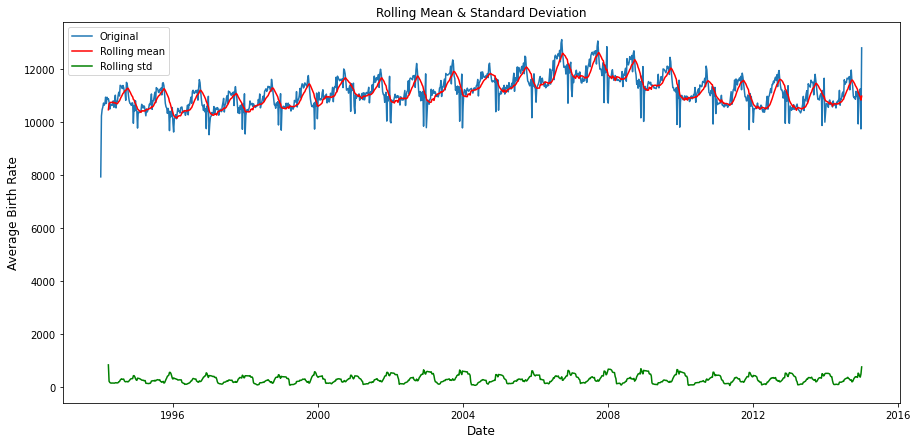

In [14]:
plt.figure(figsize=(15,7))
plt.plot(dataf["Average Birth Rate"], label='Original')
plt.plot(dataf["Average Birth Rate"].rolling(window=12).mean(), color='red', label='Rolling mean')
plt.plot(dataf["Average Birth Rate"].rolling(window=12).std(), color='green', label='Rolling std')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Birth Rate', fontsize=12)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [15]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
   
ADF_test(dataf)

Results of Dickey-Fuller Test:
Test Statistic                   -3.555876
p-value                           0.006663
Lags Used                        22.000000
Number of Observations Used    1074.000000
Critical Value (1%)              -3.436453
Critical Value (5%)              -2.864235
Critical Value (10%)             -2.568205
dtype: float64


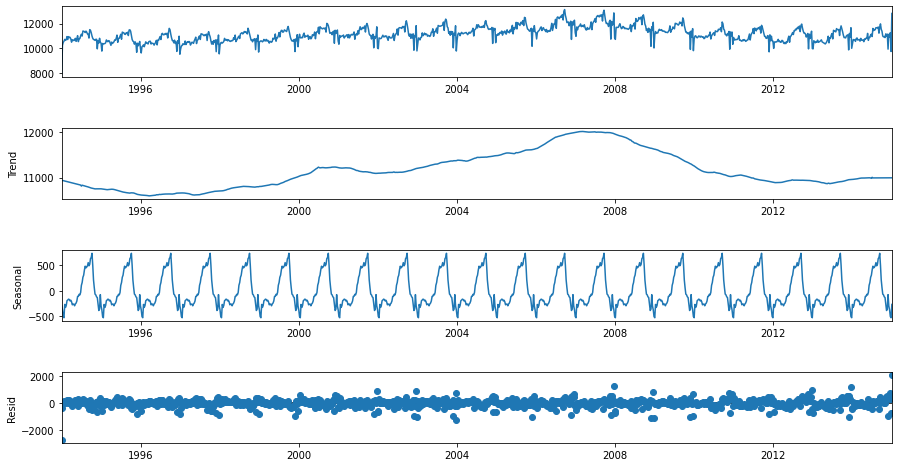

In [16]:

def seasonal_decompose (dataf):
    decomposition = sm.tsa.seasonal_decompose(dataf, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
 
trend, seasonal, residual = seasonal_decompose(dataf)

In [17]:
train_data = dataf['Average Birth Rate'][:int(len(df)*0.8)]
test_data = dataf['Average Birth Rate'][int(len(df)*0.8):]

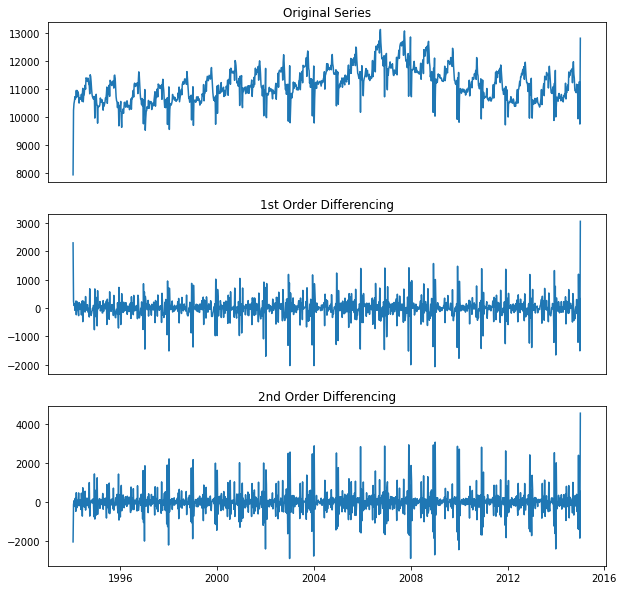

In [18]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
ax1.plot(train_data)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train_data.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train_data.diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

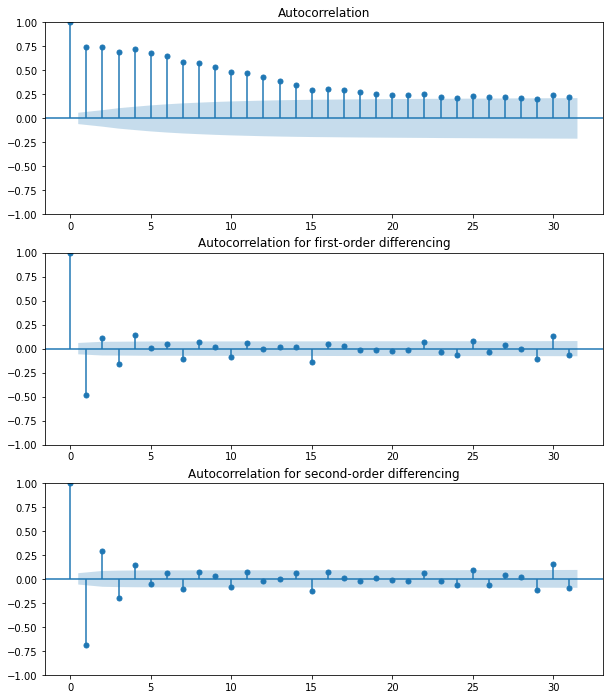

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
_ = plot_acf(train_data, ax=ax1)
_ = plot_acf(train_data.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(train_data.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


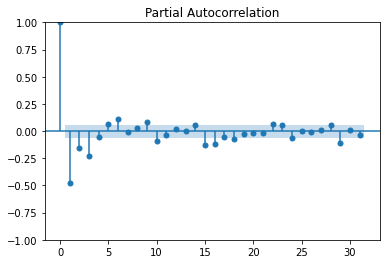

In [20]:
_ = plot_pacf(train_data.diff().dropna())

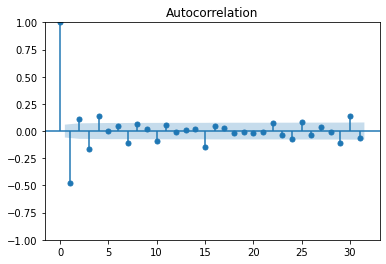

In [21]:
_ = plot_acf(train_data.diff().dropna())

In [22]:
ARIMA_model = pm.auto_arima(train_data, m=12)
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1097
Model:             SARIMAX(3, 1, 4)x(2, 0, [], 12)   Log Likelihood               -7927.601
Date:                             Sun, 26 Feb 2023   AIC                          15875.202
Time:                                     21:32:35   BIC                          15925.196
Sample:                                 01-02-1994   HQIC                         15894.118
                                      - 01-04-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2089      0.068      3.092      0.002       0.077       0.341
ar.L2          0.0686      0.075      0.909      0.363      -0.079       0.216
ar.L3         -0.8434      0.062    -13.545      0.000      -0.965      -0.721
ma.L1         -0.9030      0.075    -11.979      0.000      -1.051      -0.755
ma.L2          0.1850      0.141      1.309      0.191      -0.092       0.462
ma.L3          0.8046      0.137      5.887      0.000       0.537       1.072
ma.L4         -0.4036      0.061     -6.659      0.000      -0.522      -0.285
ar.S.L12      -0.0714      0.041     -1.749      0.080      -0.151       0.009
ar.S.L24      -0.1114      0.043     -2.578      0.010      -0.196      -0.027
sigma2       1.08e+05   3248.756     33.234      0.000    1.02e+05    1.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):              1409.90
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.19
Prob(H) (two-sided):                  0.05   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
model = ARIMA(train_data, order=(12, 1, 1))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Average Birth Rate   No. Observations:                 1097
Model:                ARIMA(12, 1, 1)   Log Likelihood               -7927.147
Date:                Sun, 26 Feb 2023   AIC                          15882.293
Time:                        21:32:39   BIC                          15952.285
Sample:                    01-02-1994   HQIC                         15908.776
                         - 01-04-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6288      0.059    -27.770      0.000      -1.744      -1.514
ar.L2         -0.9920      0.062    -15.910      0.000      -1.114      -0.870
ar.L3         -0.6124      0.064     -9.536      0.000      -0.738      -0.487
ar.L4         -0.2688      0.080     -3.346      0.001      -0.426      -0.111
ar.L5          0.1705      0.087      1.959      0.050   -6.31e-05       0.341
ar.L6          0.3449      0.085      4.035      0.000       0.177       0.512
ar.L7          0.2351      0.071      3.302      0.001       0.096       0.375
ar.L8          0.1409      0.069      2.035      0.042       0.005       0.277
ar.L9          0.1127      0.085      1.323      0.186      -0.054       0.280
ar.L10        -0.0919      0.078     -1.177      0.239      -0.245       0.061
ar.L11        -0.1534      0.070     -2.191      0.028      -0.291      -0.016
ar.L12        -0.0220      0.042     -0.520      0.603      -0.105       0.061
ma.L1          0.9630      0.051     18.736      0.000       0.862       1.064
sigma2      1.112e+05   3436.201     32.374      0.000    1.05e+05    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):              1593.26
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.16
Prob(H) (two-sided):                  0.06   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0, 0.5, 'Average Birth Rate')

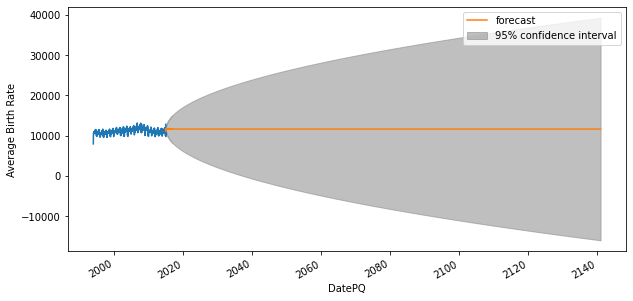

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(dataf)
plot_predict(model_fit, start=len(train_data), end=(len(df)-1), ax=axs)
plt.xlabel('DatePQ')
plt.ylabel('Average Birth Rate')

In [25]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

In [29]:
plt.style.use('fivethirtyeight')

In [30]:
my_model = Prophet(interval_width=0.95)

In [36]:
df_orig.head()

DatePQ  Average Birth Rate  Year Month Name  Day  Day Name  \
0 2000-03-04                8957  2000      March    4  Saturday   
1 2000-03-11                8739  2000      March   11  Saturday   
2 2000-03-18                8589  2000      March   18  Saturday   
3 2000-03-25                9065  2000      March   25  Saturday   
4 2001-03-03                8848  2001      March    3  Saturday   

   Month Number  Day of the week Number  
0             3                       6  
1             3                       6  
2             3                       6  
3             3                       6  
4             3                       6

In [42]:
dataf = df_orig[['DatePQ', 'Average Birth Rate']].copy()
dataf.head()

DatePQ  Average Birth Rate
0 2000-03-04                8957
1 2000-03-11                8739
2 2000-03-18                8589
3 2000-03-25                9065
4 2001-03-03                8848

In [43]:
dataf.rename(columns = {'DatePQ':'ds','Average Birth Rate':'y'}, inplace = True)

In [44]:
my_model.fit(dataf)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpev3sh6ym/_8lvvr_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpev3sh6ym/d1uqka6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79519', 'data', 'file=/tmp/tmpev3sh6ym/_8lvvr_q.json', 'init=/tmp/tmpev3sh6ym/d1uqka6p.json', 'output', 'file=/tmp/tmpev3sh6ym/prophet_modelt760tdw6/prophet_model-20230226214502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [56]:
future_dates = my_model.make_future_dataframe(periods=512, freq='W')
future_dates

ds
0    1994-01-01
1    1994-01-02
2    1994-01-03
3    1994-01-04
4    1994-01-05
...         ...
8177 2024-09-22
8178 2024-09-29
8179 2024-10-06
8180 2024-10-13
8181 2024-10-20

[8182 rows x 1 columns]

In [57]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds          yhat    yhat_lower    yhat_upper
0 1994-01-01   7680.379838   6260.528276   9197.523834
1 1994-01-02   6689.823992   5229.814868   8182.198941
2 1994-01-03  10651.034487   9241.216170  12092.729940
3 1994-01-04  11885.897330  10353.681405  13340.196467
4 1994-01-05  11675.775596  10131.431257  13170.278964

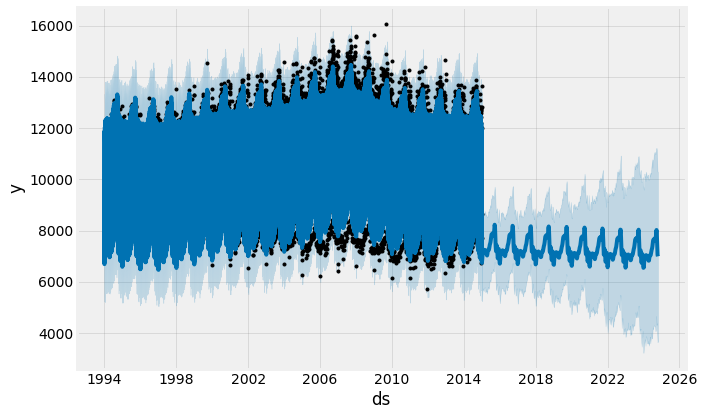

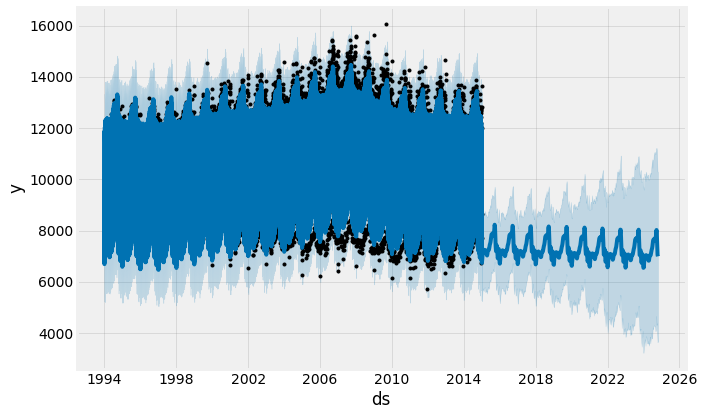

In [58]:
my_model.plot(forecast, uncertainty=True)

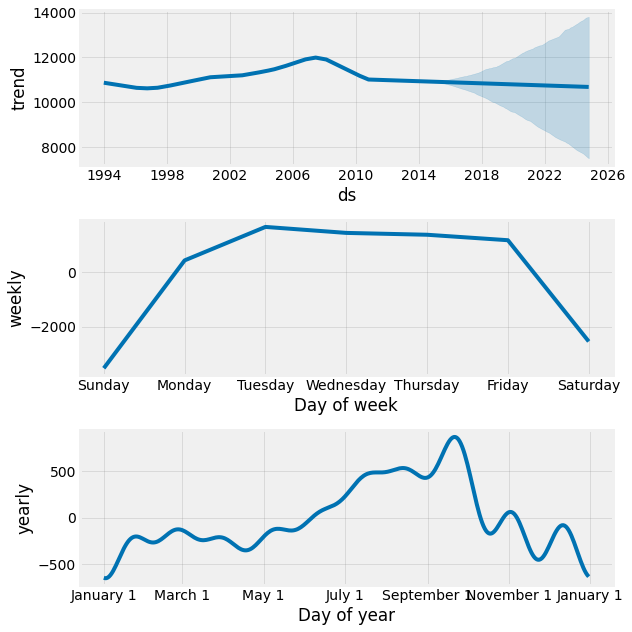

In [60]:
fig1 = my_model.plot_components(forecast)